In [34]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2

## Load iRefIndex Raw Data
#### Source (MITAB): http://irefindex.org/download/irefindex/data/archive/release_14.0/psi_mitab/MITAB2.6/9606.mitab.07042015.txt.zip
Downloaded: November 16, 2021 
Last Updated: June 11, 2021  
Notes for processing: This is the file for human protein interactions, however, not all interactions are human-human interactions. These need to be filtered. Also all ID's not without RefSeq or UniProt ID are excluded. Custom processing for this network is described below
### From iRefIndex Mapping Documentation Page:
"We have made a file which provides mappings between iRefIndex identifiers and popular external identifiers. The current files contain all UniProt and RefSeq identifiers known to the current version of iRefIndex as documented on the sources page. For specific source documentation, see the sources for each released version.  
  
Other database identifiers are provided as database/accession pairs only when the iRefIndex identifier (ROGID) does not have a corresponding UniProt or RefSeq record with an identical sequence."  
  
Therefore: Interactions containing an ROGID identifier will be removed

In [3]:

iRefIndex_Raw = pd.read_csv(wd+'Network_Data_Raw/iRefIndex/9606.mitab.06-11-2021.txt.zip',sep='\t')
print('Raw edge count in iRefIndex:', len(iRefIndex_Raw))

Raw edge count in iRefIndex: 3602589


In [4]:
# Keep only human-human interactions
iRef_Human_only = iRefIndex_Raw[(iRefIndex_Raw['taxa']=='taxid:9606(Homo sapiens)') & (iRefIndex_Raw['taxb']=='taxid:9606(Homo sapiens)')]
print('Human-Human only interactions in iRefIndex:', len(iRef_Human_only))

Human-Human only interactions in iRefIndex: 2179732


In [5]:
# Extract gene list
Human_iRef_Genes = list(set(iRef_Human_only['#uidA']).union(set(iRef_Human_only['uidB'])))

In [6]:
# Get all iRef prefixes
prefixes=[]
for gene in Human_iRef_Genes:
    prefix=gene.split(':')[0]
    if prefix not in prefixes:
        prefixes.append(prefix)
print(prefixes)

['uniprotkb', 'refseq', 'rogid']


In [7]:
# Get edge list of network
query_edgelist = iRef_Human_only[['#uidA','uidB']].values.tolist()
print(len(query_edgelist), "Human iRefIndex Edges")

2179732 Human iRefIndex Edges


## Convert Genes

In [8]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'rogid' prefix)
# This should only keep uniprotkb and refseq as queries
query_string, valid_genes, invalid_genes = gct.query_constructor(Human_iRef_Genes, exclude_prefixes=['rogid'])

31039 Valid Query Genes
918 Invalid Query Genes


In [9]:
# filter edgelist because len(invalid_genes) > 0
query_edgelist_filt = gct.filter_query_edgelist(query_edgelist, invalid_genes)

8571 / 2179732 edges with invalid nodes removed


In [10]:
# Set scopes (gene naming systems to search)
scopes = "uniprot, refseq"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 32/32 [00:22<00:00,  1.45it/s]

31290 Matched query results
Batch query complete: 22.14 seconds
31290 Matched query results


In [11]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Queries without full matching results found: 9020

196 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 24.07 seconds


## Construct Converted Network

In [12]:
# Format edge list by removing prefix indicators from all interactors
query_edgelist_filt_fmt = [[gct.get_identifier_without_prefix(edge[0]),gct.get_identifier_without_prefix(edge[1])] for edge in query_edgelist_filt]

In [13]:
# Convert network edge list to symbol
iRefIndex_edgelist_symbol = gct.convert_edgelist(query_edgelist_filt_fmt, query_to_symbol)

In [14]:
# Filter converted edge list
iRefIndex_edgelist_symbol_filt = gct.filter_converted_edgelist(iRefIndex_edgelist_symbol)

2171161 input edges
43168 self-edges removed
504796 edges with un-mapped genes removed
1158180 duplicate edges removed
Edge list filtered: 0.55 seconds
465017 Edges remaining


In [15]:
# Save filtered, converted edge list to file
gct.write_edgelist(iRefIndex_edgelist_symbol_filt, wd+'Processed_Data/Network_SIFs_Symbol/iRefIndex_Symbol_2021.sif')

Edge list saved: 0.44 seconds


# Version 1 (Original)

## Load iRefIndex Raw Data
#### Source (MITAB): http://irefindex.org/download/irefindex/data/archive/release_14.0/psi_mitab/MITAB2.6/9606.mitab.07042015.txt.zip
Downloaded: July 28, 2016  
Last Updated: April 20, 2015  
Notes for processing: This is the file for human protein interactions, however, not all interactions are human-human interactions. These need to be filtered. Also all ID's not without RefSeq or UniProt ID are excluded. Custom processing for this network is described below
### From iRefIndex Mapping Documentation Page:
"We have made a file which provides mappings between iRefIndex identifiers and popular external identifiers. The current files contain all UniProt and RefSeq identifiers known to the current version of iRefIndex as documented on the sources page. For specific source documentation, see the sources for each released version.  
  
Other database identifiers are provided as database/accession pairs only when the iRefIndex identifier (ROGID) does not have a corresponding UniProt or RefSeq record with an identical sequence."  
  
Therefore: Interactions containing an ROGID identifier will be removed

In [16]:
iRefIndex_Raw_v1 = pd.read_csv(wd+'Network_Data_Raw/iRefIndex/9606.mitab.04072015.txt',sep='\t')
print('Raw edge count in iRefIndex:', len(iRefIndex_Raw_v1))

Raw edge count in iRefIndex: 673100


In [17]:
# Keep only human-human interactions
iRef_Human_only_v1 = iRefIndex_Raw_v1[(iRefIndex_Raw_v1['taxa']=='taxid:9606(Homo sapiens)') & (iRefIndex_Raw_v1['taxb']=='taxid:9606(Homo sapiens)')]
print('Human-Human only interactions in iRefIndex:', len(iRef_Human_only_v1))

Human-Human only interactions in iRefIndex: 485030


In [18]:
# Extract gene list
Human_iRef_Genes_v1 = list(set(iRef_Human_only_v1['#uidA']).union(set(iRef_Human_only_v1['uidB'])))

In [19]:
# Get all iRef prefixes
prefixes=[]
for gene in Human_iRef_Genes_v1:
    prefix=gene.split(':')[0]
    if prefix not in prefixes:
        prefixes.append(prefix)
print(prefixes)

['uniprotkb', 'refseq', 'rogid']


In [20]:
# Get edge list of network
query_edgelist_v1 = iRef_Human_only_v1[['#uidA','uidB']].values.tolist()
print(len(query_edgelist_v1), "Human iRefIndex Edges")

485030 Human iRefIndex Edges


## Convert Genes

In [21]:
# Construct list of genes to be submitted to MyGene.Info API (remove all genes with 'rogid' prefix)
# This should only keep uniprotkb and refseq as queries
query_string_v1, valid_genes_v1, invalid_genes_v1 = gct.query_constructor(Human_iRef_Genes_v1, exclude_prefixes=['rogid'])

23906 Valid Query Genes
945 Invalid Query Genes


In [22]:
# filter edgelist because len(invalid_genes) > 0
query_edgelist_filt_v1 = gct.filter_query_edgelist(query_edgelist_v1, invalid_genes_v1)

6305 / 485030 edges with invalid nodes removed


In [23]:
# Set scopes (gene naming systems to search)
scopes = "uniprot, refseq"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v1 = gct.query_batch(query_string_v1, scopes=scopes, fields=fields)
print(len(match_list_v1), 'Matched query results')

100%|██████████| 24/24 [00:17<00:00,  1.35it/s]

24088 Matched query results
Batch query complete: 17.75 seconds
24088 Matched query results


In [24]:
match_table_trim_v1, query_to_symbol_v1, query_to_entrez_v1 = gct.construct_query_map_table(match_list_v1, valid_genes_v1)

Queries without full matching results found: 6583

137 Queries with mutliple matches found

Query mapping table/dictionary construction complete: 14.41 seconds


## Construct Converted Network

In [25]:
# Format edge list by removing prefix indicators from all interactors
query_edgelist_filt_fmt_v1 = [[gct.get_identifier_without_prefix(edge[0]),gct.get_identifier_without_prefix(edge[1])] for edge in query_edgelist_filt_v1]

In [26]:
# Convert network edge list to symbol
iRefIndex_edgelist_symbol_v1 = gct.convert_edgelist(query_edgelist_filt_fmt_v1, query_to_symbol_v1)

In [27]:
# Filter converted edge list
iRefIndex_edgelist_symbol_filt_v1 = gct.filter_converted_edgelist(iRefIndex_edgelist_symbol_v1)

478725 input edges
12077 self-edges removed
168006 edges with un-mapped genes removed
166987 duplicate edges removed
Edge list filtered: 0.12 seconds
131655 Edges remaining


In [28]:
# Save filtered, converted edge list to file
gct.write_edgelist(iRefIndex_edgelist_symbol_filt_v1, wd+'Processed_Data/Network_SIFs_Symbol/iRefIndex_Symbol_2015.sif')

Edge list saved: 0.12 seconds


# Changes

In [29]:

stats = pd.DataFrame({"v1":[673100, 485030, 131655], 
                           "v2":[3602589, 2179732, 465017]},
                           index=["input", "human_human", "filtered"])

In [32]:
nodes_v1 = set(iRefIndex_edgelist_symbol_filt_v1["symbol_n1"].values).union(set(iRefIndex_edgelist_symbol_filt_v1["symbol_n2"].values))
nodes_v2 = set(iRefIndex_edgelist_symbol_filt["symbol_n1"].values).union(set(iRefIndex_edgelist_symbol_filt["symbol_n2"].values))

Text(0, 0.5, 'Number of nodes')

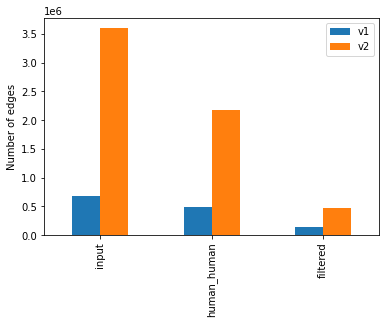

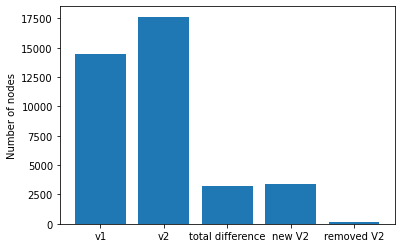

In [35]:
stats.plot.bar(ylabel="Number of edges")
plt.figure()
plt.bar(["v1", "v2", "total difference", "new V2", "removed V2"], [len(nodes_v1), len(nodes_v2), len(nodes_v2)-len(nodes_v1),
                                                           len(nodes_v2.difference(nodes_v1)), len(nodes_v1.difference(nodes_v2))])
plt.ylabel("Number of nodes")